# Quantifiers

## Imports

### TODO:
#### let the quantifier generate the scenes (turn the quantifiers into classes)
#### compare natural quantifiers reconstruction in AE to general quantifiers
#### build classifier on the hidden vectors
#### compare classification of natural classifiers to non general quantifiers
#### 

In [1]:
import numpy as np

## Define quantifiers

In [117]:
from abc import ABCMeta, abstractmethod


# define 3 symbols for, member in a and b member in b but not a and irrelevant item scenes
b_a_symbol = 0
ab_symbol = 1
dont_care_symbol = 2

symbols = [b_a_symbol,
           ab_symbol,
           dont_care_symbol]


class Quantifier(ABCMeta):

    scenes_len = 100
    
    # scene generative methods
    @classmethod
    def generate(cls):
        # sceme is generated by permutating a prototype
        return np.random.permutation(cls.generate_scene_prototype())
    
    @classmethod
    @abstractmethod
    def generate_scene_prototype(cls):
        # by default we generate a random sequence 
        while True:
            scene = np.random.choice(symbols, cls.scenes_len)
            if cls.quantifier(scene):
                return scene

    @classmethod
    def scene_prototype(cls, ab_len, b_a_len):
        return np.array([ab_symbol] * ab_len + 
                        [b_a_symbol] * b_a_len + 
                        [dont_care_symbol] * (cls.scenes_len - (ab_len + b_a_len)))

    # scene quantification methods
    @classmethod
    def quantify(cls, scene):
        # call the quantifier with as that are also bs and bs that are not as
        unique_counts = dict(zip(*np.unique(scene, return_counts=True)))
        return cls.quantification(unique_counts[ab_symbol] if ab_symbol in unique_counts else 0,
                                  unique_counts[b_a_symbol] if b_a_symbol in unique_counts else 0)
    
    @classmethod
    @abstractmethod
    def quantification(cls, ab, b_a):
        pass
        

class Most(Quantifier):
    @classmethod
    def generate_scene_prototype(cls):
        ab_len = np.random.randint(1, high=cls.scenes_len)
        b_a_len = np.random.randint(0, high=min(ab_len, cls.scenes_len - ab_len))
        return cls.scene_prototype(ab_len, b_a_len)
    
    @classmethod
    def quantification(cls, ab, b_a):
        return ab > b_a and ab > 0

# @quantify
# def some(ab, b_a):
#     return ab > 0

# @quantify
# def one(ab, b_a):
#     return ab == 1

# @quantify
# def both(ab, b_a):
#     return ab == 2

# two = both

# @quantify
# def no(ab, b_a):
#     return ab == 0

# @quantify
# def every(ab, b_a):
#     return b_a == 0


## Generated quantified scenes

In [118]:
scenes_num = 300

def generate_quantified_scenes(quantifier, scenes_len=Quantifier.scenes_len, scenes_num=scenes_num):
    # define input scenes
    scenes = [quantifier.generate() for _ in range(scenes_num)]
    # sanity check
    assert(np.all([quantifier.quantify(scene) for scene in scenes]))

    # make scenes a matrix for training
    scenes = np.concatenate(scenes, axis=0)
    # reshape input into [samples, timesteps, features]
    scenes = scenes.reshape((scenes_num, Quantifier.scenes_len, 1))
    return scenes

In [119]:
scenes = generate_quantified_scenes(Most)


## keras model

In [120]:
# keras imports

import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.utils import plot_model

In [121]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]

In [122]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'tensorflow._api.v2.config' has no attribute 'experimental_list_devices'

In [123]:
# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(len_sequences,1))))
model.add(Dropout(0.5))
model.add(RepeatVector(len_sequences))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

Epoch 1/100
300/300 [==============================] - 5s 17ms/step - loss: 0.9200
Epoch 2/100
300/300 [==============================] - 4s 14ms/step - loss: 0.4613
Epoch 3/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3704
Epoch 4/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3648
Epoch 5/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3606
Epoch 6/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3558
Epoch 7/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3499
Epoch 8/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3486
Epoch 9/100
300/300 [==============================] - 4s 15ms/step - loss: 0.3457
Epoch 10/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3429
Epoch 11/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3405
Epoch 12/100
300/300 [==============================] - 4s 14ms/step - loss: 0.3385
E

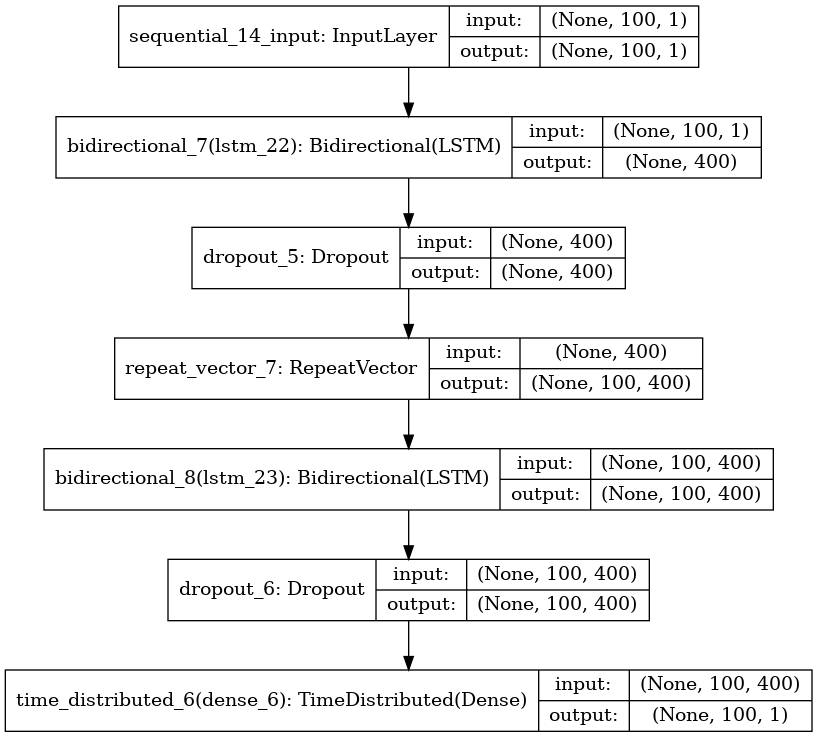

In [124]:
# fit model
num_epochs = 100
model.fit(scenes, scenes, epochs=num_epochs, verbose=1)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

## Test model predictions

In [73]:
test_scenes = generate_quantified_scenes(one, num_sequences=10)

KeyboardInterrupt: 

In [72]:
model.evaluate(test_scenes, test_scenes, verbose=1)

10/10 [==============================] - 0s 3ms/step


0.6871609091758728

In [39]:
# demonstrate recreation
yhat = model.predict(scenes[:10], verbose=2)

list(zip(yhat.reshape(10, len_sequences), scenes[:10].reshape(10, len_sequences)))

[(array([0.82966554, 1.0978786 , 1.0846545 , 1.004488  , 0.993542  ,
         1.0128545 , 1.0399047 , 1.063909  , 1.0796672 , 1.0881487 ,
         1.0914261 , 1.091444  , 1.0898751 , 1.087848  , 1.0860306 ,
         1.0847574 , 1.0841408 , 1.0841595 , 1.0847214 , 1.0857061 ,
         1.08699   , 1.0884606 , 1.0900236 , 1.0916045 , 1.0931479 ,
         1.0946153 , 1.0959821 , 1.0972342 , 1.0983664 , 1.099379  ,
         1.1002764 , 1.1010664 , 1.1017568 , 1.1023573 , 1.1028771 ,
         1.1033255 , 1.1037107 , 1.1040403 , 1.1043211 , 1.1045591 ,
         1.1047597 , 1.104927  , 1.1050649 , 1.1051766 , 1.1052643 ,
         1.1053302 , 1.1053755 , 1.1054015 , 1.1054085 , 1.1053973 ,
         1.1053683 , 1.1053206 , 1.1052544 , 1.1051697 , 1.1050652 ,
         1.1049417 , 1.1047986 , 1.1046351 , 1.1044527 , 1.1042508 ,
         1.1040317 , 1.1037967 , 1.1035484 , 1.1032907 , 1.1030283 ,
         1.1027675 , 1.1025155 , 1.1022828 , 1.1020807 , 1.1019229 ,
         1.1018257 , 1.1018083 , 1